In [1]:
# Necessary imports
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import argparse

from torch import Tensor

from qiskit import Aer, QuantumCircuit, BasicAer
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.opflow import AerPauliExpectation
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_machine_learning.neural_networks import CircuitQNN, TwoLayerQNN
from qiskit_machine_learning.connectors import TorchConnector

from qiskit.aqua.algorithms import QSVM
from qiskit.aqua.components.multiclass_extensions import AllPairs
from qiskit.aqua.utils.dataset_helper import get_feature_dimension

sys.path.insert(1, os.path.join(sys.path[0], '..'))
from quantic.data import DatasetLoader
    
# Additional torch-related imports
from torch import no_grad, manual_seed
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

import torch.optim as optim # Adam, SGD, LBFGS
from torch.nn import NLLLoss # CrossEntropyLoss, MSELoss, L1Loss, BCELoss
from qnetworks import HybridQNN_Shallow
from qnetworks import HybridQNN

#time
import timeit


In [2]:
# network args
n_classes = 2
n_qubits = 2
n_features = None
if n_features is None:
    n_features = n_qubits
network = "resnet18" #hybridqnn_shallow
# train args
batch_size = 4
epochs = 30
LR = 0.001
n_samples_train = 256 #128
n_samples_test = 64 #64
# plot args
n_samples_show = batch_size
# dataset args
shuffle = True
dataset = "MNIST" # CIFAR10 / CIFAR100, any from pytorch
dataset_cfg = ""
specific_classes_names = ['0','1'] # selected (filtered) classes
print(specific_classes_names)
use_specific_classes = len(specific_classes_names)>=n_classes
# preprocessing
input_resolution = (28,28) #(28,28) # please check n_filts required on fc1/fc2 to input to qnn
resize_interpolation = transforms.functional.InterpolationMode.BILINEAR 

# Set seed for random generators
rand_seed = np.random.randint(50)
algorithm_globals.random_seed = rand_seed
manual_seed(rand_seed) # Set train shuffle seed (for reproducibility)

if not os.path.exists("plots"):
    os.mkdir("plots")

['0', '1']


In [3]:


######## PREPARE DATASETS
time_start = timeit.timeit()

# Train Dataset
# -------------

if dataset_cfg:
    # Load a dataset configuration file
    dataset = DatasetLoader.load(from_cfg=dataset_cfg,framework='torchvision')
else:
    # Or instantate dataset manually
    dataset = DatasetLoader.load(dataset_type=dataset,
                                   num_classes=n_classes,
                                   specific_classes=specific_classes_names,
                                   num_samples_class_train=n_samples_train,
                                   num_samples_class_test=n_samples_test,
                                   framework='torchvision'
                                   )
print(f'Dataset partitions: {dataset.get_partitions()}')

X_train = dataset['train']
X_test = dataset['test']


# Get channels (rgb or grayscale)
if len(X_train.data.shape)>3: # 3d image (rgb+)
    n_channels = X_train.data.shape[3]
else: # 2d image (grayscale)
    n_channels = 1

# Set preprocessing transforms
list_preprocessing = [
    transforms.Resize(input_resolution),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.size(0)==1 else x),
] #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
X_train.transform= transforms.Compose(list_preprocessing)
X_test.transform = transforms.Compose(list_preprocessing)           

# set filtered/specific class names
classes_str = ",".join(dataset.specific_classes_names)
classes2spec = {}
specific_classes = dataset.specific_classes
for idx, class_idx in enumerate(specific_classes):
    classes2spec[class_idx]=idx

classes_list = dataset.classes
n_samples = n_samples_test

Dataset partitions: ['train', 'test']


In [4]:
# Define torch dataloader with filtered data
train_loader = DataLoader(X_train, batch_size=batch_size, shuffle=shuffle)
# Define torch dataloader with filtered data
test_loader = DataLoader(X_test, batch_size=batch_size, shuffle=shuffle)

time_end = timeit.timeit()
time_elapsed = time_end - time_start
print(f"Dataloaders elapsed time: {time_elapsed} s")

Dataloaders elapsed time: -0.0005266517400741577 s


<Figure size 432x288 with 0 Axes>

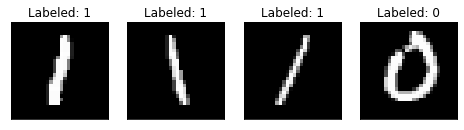

<Figure size 432x288 with 0 Axes>

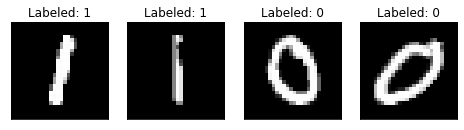

<Figure size 432x288 with 0 Axes>

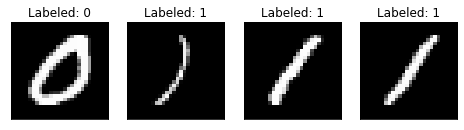

<Figure size 432x288 with 0 Axes>

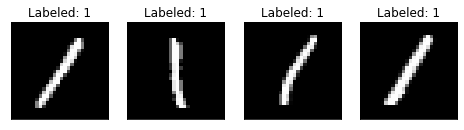

In [5]:
##### VISUALIZE LABELS
data_iter = iter(train_loader)
n_samples_show_alt = n_samples_show
while n_samples_show_alt > 0:
    try:
        images, targets = data_iter.__next__()
    except:
        break
    plt.clf()
    fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(n_samples_show*2, batch_size*3))
    if n_samples_show == 1:
        axes = [axes]
    for idx, image in enumerate(images):
        axes[idx].imshow(np.moveaxis(images[idx].numpy().squeeze(),0,-1))
        axes[idx].set_xticks([])
        axes[idx].set_yticks([])
        class_label = classes_list[targets[idx].item()]
        axes[idx].set_title("Labeled: {}".format(class_label))
        if idx > n_samples_show:
            #plt.savefig(f"plots/{dataset}_classification{classes_str}_subplots{n_samples_show_alt}_lr{LR}_labeled_q{n_qubits}_{n_samples}samples_bsize{batch_size}_{epochs}epoch.png")
            break
    plt.show()
    n_samples_show_alt -= 1
    

In [6]:
##### DESIGN NETWORK
time_start = timeit.timeit()



# init network
if network == "hybridqnn_shallow":
    ## predefine number of input filters to fc1 and fc2
    # examples: 13456 for (128x128x1), 59536 for (256x256x1), 256 for (28x28x1), 400 for (28x28x3) or (35x35x1) 
    if n_channels == 1:
        n_filts_fc1 = int(((((input_resolution[0]-4)/2)-4)/2)**2)*16
    else:
        n_filts_fc1 = int(((((input_resolution[0]+7-4)/2)-4)/2)**2)*16
    n_filts_fc2 = int(n_filts_fc1 / 4)

    # declare quantum instance
    qi = QuantumInstance(Aer.get_backend("aer_simulator_statevector"))
    # Define QNN
    feature_map = ZZFeatureMap(n_features)
    ansatz = RealAmplitudes(n_qubits, reps=1)
    # REMEMBER TO SET input_gradients=True FOR ENABLING HYBRID GRADIENT BACKPROP
    qnn = TwoLayerQNN(
        n_qubits, feature_map, ansatz, input_gradients=True, exp_val=AerPauliExpectation(), quantum_instance=qi
    )
    print(qnn.operator)
    qnn.circuit.draw(output="mpl",filename=f"plots/qnn{n_qubits}_{n_classes}classes.png")
    #from qiskit.quantum_info import Statevector
    #from qiskit.visualization import plot_bloch_multivector
    #state = Statevector.from_instruction(qnn.circuit)
    #plot_bloch_multivector(state)
    model = HybridQNN_Shallow(n_classes = n_classes, n_qubits = n_qubits, n_channels = n_channels, n_filts_fc1 = n_filts_fc1, n_filts_fc2 = n_filts_fc2, qnn = qnn)
    print(model)

    # Define model, optimizer, and loss function
    optimizer = optim.Adam(model.parameters(), lr=LR)
    loss_func = NLLLoss()

elif network == "QSVM":
    backend = BasicAer.get_backend('qasm_simulator')

    # todo: fix this transformation for QSVM
    train_input = X_train.targets
    test_input = X_test.targets
    total_array = np.concatenate([test_input[k] for k in test_input])
    #
    feature_map = ZZFeatureMap(feature_dimension=get_feature_dimension(train_input),
                               reps=2, entanglement='linear')
    svm = QSVM(feature_map, train_input, test_input, total_array,
               multiclass_extension=AllPairs())
    quantum_instance = QuantumInstance(backend, shots=1024,
                                       seed_simulator=algorithm_globals.random_seed,
                                       seed_transpiler=algorithm_globals.random_seed)
else:
    model = HybridQNN(backbone=network,pretrained=True,n_qubits=n_qubits,n_classes=n_classes)
    # Define model, optimizer, and loss function
    optimizer = optim.Adam(model.network.parameters(), lr=LR)
    loss_func = NLLLoss()
    
time_end = timeit.timeit()
time_elapsed = time_end - time_start
print(f"Network init elapsed time: {time_elapsed} s")

ComposedOp([
  OperatorMeasurement(1.0 * ZZ),
  CircuitStateFn(
       ┌──────────────────────────┐┌──────────────────────────────────────┐
  q_0: ┤0                         ├┤0                                     ├
       │  ZZFeatureMap(x[0],x[1]) ││  RealAmplitudes(θ[0],θ[1],θ[2],θ[3]) │
  q_1: ┤1                         ├┤1                                     ├
       └──────────────────────────┘└──────────────────────────────────────┘
  )
])
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): Re

In [ ]:
################# TRAIN
# Start training
time_start = timeit.timeit()

if network != "QSVM":
    if "vgg" in network or "resnet" in network:
        model.network.train()  # Set model to training mode
    if network == "hybridqnn_shallow":
        model.train()  # Set model to training mode
        
    loss_list = []  # Store loss history
    for epoch in range(epochs):
        total_loss = []
        for batch_idx, (data, target) in enumerate(train_loader):

            optimizer.zero_grad(set_to_none=True)  # Initialize gradient
            output = model(data)  # Forward pass

            # change target class identifiers towards 0 to n_classes
            for sample_idx, value in enumerate(target):
                target[sample_idx]=classes2spec[target[sample_idx].item()]

            loss = loss_func(output, target)  # Calculate loss
            loss.backward()  # Backward pass
            optimizer.step()  # Optimize weights
            total_loss.append(loss.item())  # Store loss
            print(f"Batch {batch_idx}, Loss: {total_loss[-1]}")
        loss_list.append(sum(total_loss) / len(total_loss))
        print("Training [{:.0f}%]\tLoss: {:.4f}".format(100.0 * (epoch + 1) / epochs, loss_list[-1]))

    # Plot loss convergence
    plt.clf()
    plt.plot(loss_list)
    plt.title("Hybrid NN Training Convergence")
    plt.xlabel("Training Iterations")
    plt.ylabel("Neg. Log Likelihood Loss")
    #plt.savefig(f"plots/{dataset}_classification{classes_str}_hybridqnn_q{n_qubits}_{n_samples}samples_lr{LR}_bsize{batch_size}.png")
    plt.show()
    
elif network == "QSVM":
    result = svm.run(quantum_instance)
    for k,v in result.items():
        print(f'{k} : {v}')

time_end = timeit.timeit()
time_elapsed = time_end - time_start
print(f"Training time: {time_elapsed} s")

Batch 0, Loss: -0.4166314899921417
Batch 1, Loss: -0.10218349099159241
Batch 2, Loss: -0.6114848852157593
Batch 3, Loss: -0.5028235912322998
Batch 4, Loss: -0.42455655336380005
Batch 5, Loss: -0.636171281337738
Batch 6, Loss: -0.4483354091644287
Batch 7, Loss: -0.3133126497268677
Batch 8, Loss: -0.3969833254814148
Batch 9, Loss: -0.39715680480003357
Batch 10, Loss: -0.4889727830886841
Batch 11, Loss: -0.5164608955383301
Batch 12, Loss: -0.3789302110671997
Batch 13, Loss: -0.5427126288414001
Batch 14, Loss: -0.708215594291687
Batch 15, Loss: -0.6985499262809753
Batch 16, Loss: -0.7378766536712646
Batch 17, Loss: -0.3623179793357849
Batch 18, Loss: -0.27029553055763245
Batch 19, Loss: -0.5685149431228638
Batch 20, Loss: -0.6514142751693726
Batch 21, Loss: -0.577258288860321
Batch 22, Loss: -0.5802364349365234
Batch 23, Loss: -0.35480570793151855
Batch 24, Loss: -0.4911598265171051
Batch 25, Loss: -0.5271931886672974
Batch 26, Loss: -0.2926080822944641
Batch 27, Loss: -0.843526303768158
B

Batch 113, Loss: -0.1482396423816681
Batch 114, Loss: -0.7174340486526489
Batch 115, Loss: -0.691590428352356
Batch 116, Loss: -0.5501775741577148
Batch 117, Loss: -0.3070457875728607
Batch 118, Loss: -0.8195841908454895
Batch 119, Loss: -0.5544508695602417
Batch 120, Loss: -0.5713567733764648
Batch 121, Loss: -0.3039945960044861
Batch 122, Loss: -0.7676150798797607
Batch 123, Loss: -0.34004926681518555
Batch 124, Loss: -0.6915640830993652
Batch 125, Loss: -0.33651190996170044
Batch 126, Loss: -0.10793182253837585
Batch 127, Loss: -0.1952713429927826
Training [7%]	Loss: -0.5028
Batch 0, Loss: -0.6748136281967163
Batch 1, Loss: -0.5775800943374634
Batch 2, Loss: -0.5898263454437256
Batch 3, Loss: -0.6121124029159546
Batch 4, Loss: -0.8885807394981384
Batch 5, Loss: -0.5715498328208923
Batch 6, Loss: -0.7358931303024292
Batch 7, Loss: -0.6382240056991577
Batch 8, Loss: -0.19505596160888672
Batch 9, Loss: -0.47128716111183167
Batch 10, Loss: -0.48618897795677185
Batch 11, Loss: -0.5504150

Batch 82, Loss: -0.2534886598587036
Batch 83, Loss: -0.8142794370651245
Batch 84, Loss: -0.6910189390182495
Batch 85, Loss: -0.40203291177749634
Batch 86, Loss: -0.5937817096710205
Batch 87, Loss: -0.5151182413101196
Batch 88, Loss: -0.2561958134174347
Batch 89, Loss: -0.5347195267677307
Batch 90, Loss: -0.4451332092285156
Batch 91, Loss: -0.45695531368255615
Batch 92, Loss: -0.46514344215393066
Batch 93, Loss: -0.7831294536590576
Batch 94, Loss: -0.6098117232322693
Batch 95, Loss: -0.8277483582496643
Batch 96, Loss: -0.5348843336105347
Batch 97, Loss: -0.5818649530410767
Batch 98, Loss: -0.4227563142776489
Batch 99, Loss: -0.3933160901069641
Batch 100, Loss: -0.530808687210083
Batch 101, Loss: -0.9238342046737671
Batch 102, Loss: -0.33896347880363464
Batch 103, Loss: -0.4428390562534332
Batch 104, Loss: -0.7551522254943848
Batch 105, Loss: -0.670065701007843
Batch 106, Loss: -0.9104184508323669
Batch 107, Loss: -0.3385244309902191
Batch 108, Loss: -0.7850823402404785
Batch 109, Loss: 

Batch 51, Loss: -0.6725867390632629
Batch 52, Loss: -0.7286524772644043
Batch 53, Loss: -0.39106810092926025
Batch 54, Loss: -0.7725070118904114
Batch 55, Loss: -0.7600772976875305
Batch 56, Loss: -0.3178309202194214
Batch 57, Loss: -1.157450556755066
Batch 58, Loss: -0.4001496434211731
Batch 59, Loss: -0.24238459765911102
Batch 60, Loss: -1.1380767822265625
Batch 61, Loss: -1.0870593786239624
Batch 62, Loss: -0.4060516357421875
Batch 63, Loss: -0.6530207395553589
Batch 64, Loss: -0.30477994680404663
Batch 65, Loss: -0.03139546513557434
Batch 66, Loss: -1.1161043643951416
Batch 67, Loss: -1.0703120231628418
Batch 68, Loss: -0.38148418068885803
Batch 69, Loss: -0.664427638053894
Batch 70, Loss: -0.26320987939834595
Batch 71, Loss: -0.7414629459381104
Batch 72, Loss: -0.3447725176811218
Batch 73, Loss: -0.8242151141166687
Batch 74, Loss: -0.8179298043251038
Batch 75, Loss: -0.7317405939102173
Batch 76, Loss: -0.4664440155029297
Batch 77, Loss: -0.6517561674118042
Batch 78, Loss: -0.35157

Batch 20, Loss: -1.0141232013702393
Batch 21, Loss: -1.0651086568832397
Batch 22, Loss: -0.7434109449386597
Batch 23, Loss: -0.7731097936630249
Batch 24, Loss: -0.7240459322929382
Batch 25, Loss: -1.0444295406341553
Batch 26, Loss: -1.1149481534957886
Batch 27, Loss: -1.152788758277893
Batch 28, Loss: -0.7203387022018433
Batch 29, Loss: -0.6891164779663086
Batch 30, Loss: -0.7136101126670837
Batch 31, Loss: -1.2263816595077515
Batch 32, Loss: -0.759697437286377
Batch 33, Loss: -1.2597377300262451
Batch 34, Loss: -1.2614613771438599
Batch 35, Loss: -0.8826995491981506
Batch 36, Loss: -0.8549783825874329
Batch 37, Loss: -1.226097583770752
Batch 38, Loss: -0.9453562498092651
Batch 39, Loss: -0.9268449544906616
Batch 40, Loss: -0.745486855506897
Batch 41, Loss: -0.280791312456131
Batch 42, Loss: -0.903540313243866
Batch 43, Loss: -1.0569478273391724
Batch 44, Loss: -1.2414264678955078
Batch 45, Loss: -1.2485935688018799
Batch 46, Loss: -0.21878460049629211
Batch 47, Loss: -0.87648403644561

Batch 119, Loss: -0.9599918723106384
Batch 120, Loss: -1.3477214574813843
Batch 121, Loss: -0.5058302283287048
Batch 122, Loss: -0.5169326066970825
Batch 123, Loss: -1.4677510261535645
Batch 124, Loss: -0.3212987184524536
Batch 125, Loss: -1.1450920104980469
Batch 126, Loss: -0.17790070176124573
Batch 127, Loss: -1.3360579013824463
Training [30%]	Loss: -0.8685
Batch 0, Loss: -0.49251145124435425
Batch 1, Loss: -1.2882521152496338
Batch 2, Loss: -1.5236196517944336
Batch 3, Loss: 0.0063816457986831665
Batch 4, Loss: -1.2343175411224365
Batch 5, Loss: -0.9745916128158569
Batch 6, Loss: -0.8389434218406677
Batch 7, Loss: -0.993798017501831
Batch 8, Loss: -1.29555082321167
Batch 9, Loss: -0.5119680762290955
Batch 10, Loss: -0.4302597939968109
Batch 11, Loss: -1.4083819389343262
Batch 12, Loss: -0.9877331852912903
Batch 13, Loss: -0.1288444846868515
Batch 14, Loss: -0.5548493266105652
Batch 15, Loss: -0.9021363854408264
Batch 16, Loss: -0.2748590409755707
Batch 17, Loss: 0.00615377724170684

In [ ]:
######## TEST
time_start = timeit.timeit()

if network != "QSVM":
    if "vgg" in network or "resnet" in network:
        model.network.eval()  # Set model to eval mode
    if network == "hybridqnn_shallow":
        model.eval()  # Set model to eval mode
    with no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            if len(output.shape) == 1:
                output = output.reshape(1, *output.shape)
            pred = output.argmax(dim=1, keepdim=True)

            # change target class identifiers towards 0 to n_classes
            for sample_idx, value in enumerate(target):
                target[sample_idx]=classes2spec[target[sample_idx].item()]

            correct += pred.eq(target.view_as(pred)).sum().item()
            loss = loss_func(output, target)
            total_loss.append(loss.item())

        print(
            "Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%".format(
                sum(total_loss) / len(total_loss), correct / len(test_loader) / batch_size * 100
            )
        )

    time_end = timeit.timeit()
    time_elapsed = time_end - time_start
    print(f"Test time: {time_elapsed} s")
    
    


In [ ]:
# Plot predicted labels
n_samples_show_alt = n_samples_show
while n_samples_show_alt > 0:
    plt.clf()
    count = 0
    fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(n_samples_show*2, batch_size*3))
    if n_samples_show == 1:
        axes = [axes]
    for batch_idx, (data, target) in enumerate(test_loader):    
        if count == n_samples_show:
            #plt.savefig(f"plots/{dataset}_classification{classes_str}_subplots{n_samples_show_alt}_lr{LR}_pred_q{n_qubits}_{n_samples}samples_bsize{batch_size}_{epochs}epoch.png")
            plt.show()
            break
        output = model(data)
        if len(output.shape) == 1:
            output = output.reshape(1, *output.shape)
        pred = output.argmax(dim=1, keepdim=True)
        for sample_idx in range(batch_size):
            try:
                class_label = classes_list[specific_classes[pred[sample_idx].item()]]
            except:
                class_label = classes_list[specific_classes[pred[sample_idx].item()-1]]
            axes[count].imshow(np.moveaxis(data[sample_idx].numpy().squeeze(),0,-1))
            axes[count].set_xticks([])
            axes[count].set_yticks([])
            axes[count].set_title(class_label)
            count += 1
    n_samples_show_alt -= 1

### 